# Project 2: inverse kinematics and resolved rate control

In this project, we will implement an inverse kinematics algorithm and controllers for the Kuka iiwa 14 robot using the results from Project 1.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.

As a reminder, the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa) has 7 revolute joints and its kinematics is described in the picture below:

![](./kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Setup

Run the cell below only once when resetting the runtime in Colab - this will not do anything when running on a local Jupyter Notebook.

In [1]:
## check if we are in Google Colab
try:
    import google.colab
    RUNNING_IN_COLAB = True
    print('detected Colab - setting up environment')
    # then we need to install the conda environment
    try:
        import condacolab
        condacolab.check()
    except:
        !pip install -q condacolab
        import condacolab
        condacolab.install()
except:
    RUNNING_IN_COLAB = False

In [2]:
# after installing condalab, the runtime restarts
# -> need to check for colab env once more here
try:
    import google.colab
    RUNNING_IN_COLAB = True
except Exception as e:
    RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    try:
        # Check if packages are installed or not. If not, install them.
        import pinocchio
    except:
        # Install pinocchio, meschat-python 
        !conda install pinocchio meshcat-python
       
    # get the class repo - first check if it exists
    import os, sys
    if not os.path.isdir('/content/ROB6003/Project2'):
      print('cloning LAB repository')
      os.chdir('/content')
      !git clone https://github.com/righetti/ROB6003.git
      print('cloning done')
    else:
      print('lab repos was found, skipping cloning')
    print('done configuring for Colab')
    sys.path.append('/content/ROB6003/Project2/')
    os.chdir('/content/ROB6003/Project2/')
    print('done adding system path and changing directory.')


# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [9]:
import numpy as np
import robot_visualizer
import time

import matplotlib.pyplot as plt

robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/
You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7002/static/


C:\Users\Shantanu\anaconda3\lib\site-packages\pinocchio\shortcuts.py:45: UserWarning: You passed package dir(s) via argument geometry_model and provided package_dirs.
  geom_model = pin.buildGeomFromUrdf(model, filename, geometry_type, package_dirs)


# Displaying an arbitrary configuration

As in the previous project, you can use the following function to display arbitrary configurations of the robot

In [10]:
# here we display an arbitrary configuration of the robot
q = np.random.sample([7])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q)

we show the configuration for the angles [0.49237462 0.70443551 0.96890122 0.92883571 0.18185652 0.91448159
 0.7246827 ]


In [11]:
import numpy as np
import scipy.linalg as sc

def vec_to_skew(vector):
  

    vector = np.array(vector)

    return np.array([[0, -vector.item(2), vector.item(1)],
                     [vector.item(2), 0, -vector.item(0)],
                     [-vector.item(1), vector.item(0), 0]])
def skew_to_vec(matrix):
  
      return np.array([[matrix[2, 1]], 
                     [matrix[0, 2]], 
                     [matrix[1, 0]]])
def twist_to_skew(vector):
      [a,b] = np.split(vector,2)
      a=vec_to_skew(a)
      a=np.concatenate((a,b), axis=1)
      a = np.concatenate((a, np.array([[0,0,0,0]])), axis=0);
      return a
def skew_to_twist(matrix):
  return np.array([[matrix[2, 1]], 
                    [matrix[0, 2]], 
                    [matrix[1, 0]],
                    [matrix[0, 3]],
                    [matrix[1, 3]],
                    [matrix[2, 3]]])
def getAdjoint(matrix):
    r = matrix[:3,:3]
    p = matrix[0:3,3]
    A_u = np.concatenate((r,np.zeros((3,3),int)), axis=1)
    A_d = np.concatenate(((vec_to_skew(p) @ r),r), axis=1)
    a=np.concatenate((A_u,A_d), axis=0)
    return a

def inverse(matrix):
    return sc.inv(matrix)

def exp_twist_bracket(matrix):
    return sc.expm(twist_to_skew(matrix))

def forward_kinematics(theta):
  M=np.array([[1,0,0,0], [0,1,0,0],[0,0,1,1.301],[0,0,0,1]])

  T1=np.array([[0.000],[0.000],[1.000],[0.000],[0.000],[0.000]])
  T2=np.array([[0.000],[1.000],[0.000],[-0.360],[0.000],[0.000]])
  T3=np.array([[0.000],[0.000],[1.000],[0.000],[0.000],[0.000]])
  T4=np.array([[0.000],[-1.000],[0.000],[0.780],[0.000],[0.000]])
  T5=np.array([[0.000],[0.000],[1.000],[0.000],[0.000],[0.000]])
  T6=np.array([[0.000],[1.000],[0.000],[-1.180],[0.000],[0.000]])
  T7=np.array([[0.000],[0.000],[1.000],[0.000],[0.000],[0.000]])
  T=np.concatenate((T1,T2,T3,T4,T5,T6,T7), axis=1)
  a= np.eye(4);
  for i in range(theta.size):
    a = a @ (exp_twist_bracket(np.reshape(T[:, i], (6, 1)) * theta[i]))
  M = a @ M
  M = np.round(M,3)
  return M 

def get_space_jacobian(theta):
  S1=np.array([[0.000],[0.000],[1.000],[0.000],[0.000],[0.000]])
  S2=np.array([[0.000],[1.000],[0.000],[-0.360],[0.000],[0.000]])
  S3=np.array([[0.000],[0.000],[1.000],[0.000],[0.000],[0.000]])
  S4=np.array([[0.000],[-1.000],[0.000],[0.780],[0.000],[0.000]])
  S5=np.array([[0.000],[0.000],[1.000],[0.000],[0.000],[0.000]])
  S6=np.array([[0.000],[1.000],[0.000],[-1.180],[0.000],[0.000]])
  S7=np.array([[0.000],[0.000],[1.000],[0.000],[0.000],[0.000]])
  S=np.concatenate((S1,S2,S3,S4,S5,S6,S7), axis=1)
  s = np.eye(4)
  J = np.reshape(S[:,0],(6,1))
  for i in range(1,theta.size):
    s = s @ exp_twist_bracket(np.reshape(S[:,i-1],(6,1)) * theta[i-1])
    jt = getAdjoint(s) @ S[:,i]
    jt = np.reshape(jt,(6,1))
    J = np.concatenate((J, jt), axis=1)
  J=np.round(J,3)
  return(J)

#define jacobian
def get_spaceoribody_jacobian(T, J):
  #T = inverse(T)
  #T = np.linalg.pinv(T)
  #r = T[:3,:3]
  r = np.eye(3)
  p = -T[0:3,3]
  A_u = np.concatenate((np.eye(3),np.zeros((3,3),int)), axis=1)
  A_d = np.concatenate(((vec_to_skew(p) @ r),r), axis=1)
  a=np.concatenate((A_u,A_d), axis=0)
  return a @ J

def sudo_jacobian(J):
  J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
  return J_sudo
def sudo_jacobian_regularization(J, epsilon):
    
  J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J) + epsilon*np.eye(3)))
  return J_sudo

## Question 1: inverse kinematics
* Write a function ``compute_IK_position`` that gets a desired end-effector 3D position (in spatial frame) and returns a vector of joint angles that solves the inverse kinematics problem
* The file ``desired_end_effector_positions.npy`` contains a sequence of 10 desired end-effector positions. For all the positions attainable by the robot, compute an inverse kinematics solution. For the positions for which an inverse kinematics solution does not exist, what is the issue and how close can you get the end-effector to the desired position?
* Write a function ``compute_IK_position_nullspace`` that solves the inverse kinematics problem and additionally uses joint redundancy (i.e. the nullspace) to try and keep the joints close to the following configuration $[1,1,-1,-1,1,1,1]$. Explain how you used the nullspace to implement this function.
* Use this new function to reach the positions set in the file ``desired_end_effector_positions.npy``, how do the solutions compare to the first ones you found?

In [12]:
def compute_IK_position2(position):
  theta = np.array([0,0,0,0,0,0,0])
  theta = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1])
  #theta = np.random.rand(1,7)
  alpha = 0.02
  epsilon = 0.0001
  #position = np.array([-0.5,0.6,0.2])
  for i in range(0):
    T = forward_kinematics(theta)
    J = get_space_jacobian(theta)
    J = get_spaceoribody_jacobian(T,J)
    J = J[3:,:]
    error = position - T[0:3,3]
    error_v = np.linalg.norm(error)
    J_sudo = np.linalg.pinv(J)
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
    dq = J_sudo @ error
    theta =  dq
    #theta = np.arctan2(np.sin(theta), np.cos(theta))
    print(error)


  for i in range(10000):
    
    T = forward_kinematics(theta)
    J = get_space_jacobian(theta)
    J = get_spaceoribody_jacobian(T,J)
    #J = getAdjoint(np.linalg.inv(T))@J
    J = J[3:,:]
    error = position - T[0:3,3]
    error_v = np.linalg.norm(error)
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J) + epsilon*np.eye(3)))
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
    J_sudo = np.linalg.pinv(J)
    dq = J_sudo @ error
    theta = theta + alpha * dq
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    if(error_v<0.001):
      print("Sucess")  
      break
    #print(error_v)
  #return theta, error_v
  return theta

In [13]:
def compute_IK_position3(position):
    theta = np.array([0,0,0,0,0,0,0])
    theta = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1])
    #theta = np.random.rand(1,7)
    alpha = 0.02
    epsilon = 0.0001
    #position = np.array([-0.5,0.6,0.2])
    for i in range(1):
        T = forward_kinematics(theta)
        J = get_space_jacobian(theta)
        J = get_spaceoribody_jacobian(T,J)
        J = J[3:,:]
        error = position - T[0:3,3]
        error_v = np.linalg.norm(error)
        J_sudo = np.linalg.pinv(J)
        #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
        dq = J_sudo @ error
        theta =  dq
        #theta = np.arctan2(np.sin(theta), np.cos(theta))
        print(error)


    for i in range(10000):

        T = forward_kinematics(theta)
        J = get_space_jacobian(theta)
        J = get_spaceoribody_jacobian(T,J)
        #J = getAdjoint(np.linalg.inv(T))@J
        J = J[3:,:]
        error = position - T[0:3,3]
        error_v = np.linalg.norm(error)
        #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J) + epsilon*np.eye(3)))
        #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
        J_sudo = np.linalg.pinv(J)
        dq = J_sudo @ error
        theta = theta + alpha * dq
        #theta = np.arctan2(np.sin(theta), np.cos(theta))
        if(error_v<0.001):
            print("Sucess")  
            break
        #print(error_v)
    return theta, error_v

In [14]:
def compute_IK_position(position):
  theta = np.array([0,0,0,0,0,0,0])
  alpha = 0.1
  epsilon = 0.0001

  #position = np.array([-0.5,0.6,0.2])
  for i in range(0):
    T = forward_kinematics(theta)
    J = get_space_jacobian(theta)
    J = get_spaceoribody_jacobian(T,J)
    J = J[3:6,:]
    error = position - T[0:3,3]
    error_v = np.linalg.norm(error)
    J_sudo = np.linalg.pinv(J)
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
    dq = J_sudo @ error
    theta =  dq
    print(error)


  for i in range(1000):
    
    T = forward_kinematics(theta)
    J = get_space_jacobian(theta)
    J_frame3 = get_spaceoribody_jacobian(T,J)
    #J = getAdjoint(np.linalg.inv(T))@J
    J_inv = np.linalg.pinv(J_frame3)

    J_inv = J_inv[:, 3:6]
    error = position - T[0:3,3]
    error_v = np.linalg.norm(error)
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J) + epsilon*np.eye(3)))
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
    #J_sudo = np.linalg.pinv(J)
    dq = J_inv @ error
    theta = theta + alpha * dq
    if(error_v<0.001):
      print("Sucess")  
      break
    #print(error_v)
  #return theta, error_v
  return theta

In [15]:
def compute_IK_position_nullspace(position):
  theta = np.array([0,0,0,0,0,0,0])
  alpha = 0.1
  epsilon = 0.00001
  for i in range(1):
    T = forward_kinematics(theta)
    J = get_space_jacobian(theta)
    J = get_spaceoribody_jacobian(T,J)
    J = J[3:6,:]
    error = position - T[0:3,3]
    error_v = np.linalg.norm(error)
    J_sudo = np.linalg.pinv(J)
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
    dq = J_sudo @ error
    theta =  dq
    print(error)


  for i in range(10000):
    T = forward_kinematics(theta)
    J = get_space_jacobian(theta)
    J = get_spaceoribody_jacobian(T,J)
    J = J[3:,:]
    error = position - T[0:3,3]
    error_v = np.linalg.norm(error)
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J) + epsilon*np.eye(3)))
    #J_sudo = (np.transpose(J) @ inverse(J @ np.transpose(J)))
    J_sudo = np.linalg.pinv(J)
    nul_P = np.eye(7) - J_sudo @ J
    q_pose = np.array([1,1,-1,-1,1,1,1])
    #q_pose = np.array([0,0,0,0,0,0,0])
    null_Q = (q_pose - theta)
    #J_sudo = np.linalg.pinv(J)
    dq = (J_sudo @ error) + (nul_P @ null_Q)
    theta = theta + (alpha * dq)
    if(error_v<0.001):
      print("Sucess")  
      break
    #print(error_v)
  return theta, error_v

In [8]:
## a script to load the desired end effector positions and display each of them every second
## you maybe modify this script to test your code

# load the file
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    
# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7,1]))
    
# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:,i])
    time.sleep(1.)

In [55]:
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    theta = []
    error = []
    for i in range(10):
        a,b = compute_IK_position3(desired_endeff[:,i])
        theta.append(a)
        error.append(b)

[ 0.32939707 -0.95946426 -0.28083292]
[ 0.26144311  0.57040228 -0.52012766]
Sucess
[-0.36953973  0.30178196 -0.62916558]
Sucess
[-0.17221891 -0.20142012 -0.19075793]
Sucess
[ 0.2310429  -0.3921786  -0.56119318]
Sucess
[-0.20573455  0.26526613  0.02046463]
[-0.85193568  0.42269676 -0.00450942]
[-0.54081569 -0.75469487 -0.5340968 ]
[-0.00780386 -0.01782287 -0.41032557]
Sucess
[ 0.65073966 -0.18953133 -0.6104953 ]
Sucess


In [57]:
print(theta)
print(error)

[array([-1.21216215,  1.978781  , -0.25966358,  1.7397395 ,  0.97031557,
       -0.77441971, -0.2271579 ]), array([ 0.78143573,  1.60974559,  2.68832224, -1.25539094,  2.44340195,
        0.35794272, -0.47904396]), array([ 2.02415495,  0.4447174 ,  0.6324689 , -1.36716257,  2.42611928,
       -2.89514374, -0.65346482]), array([ 2.01668958, -0.71665893,  0.36855513, -1.24838011, -0.44661505,
       -0.78105049, -0.1725567 ]), array([-0.05205253,  0.60405866,  1.86572114,  1.6381175 ,  0.697895  ,
        1.88632915, -0.48089357]), array([ 2.04656528e+00,  3.34986723e-01,  1.65316498e+00, -3.63331015e-04,
        2.58405838e+00, -4.50771176e-03, -8.47551047e-02]), array([-0.47299276, -0.73554102, -1.37397249,  0.04942642,  2.39874936,
       -0.14769304,  0.27845298]), array([-1.95563915,  1.26000525, -2.32736241, -0.32619621, -2.23313791,
       -0.25120674, -2.03541193]), array([ 1.62183583,  1.09315459,  0.18250697,  1.97352434,  1.35558979,
        0.35734971, -0.38859997]), array([ 

In [61]:
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    theta = []
    error = []
    for i in range(10):
        a,b = compute_IK_position_nullspace(desired_endeff[:,i])
        theta.append(a)
        error.append(b)

[ 0.38339707 -0.95646426 -0.28383292]
[ 0.31544311  0.57340228 -0.52312766]
Sucess
[-0.31553973  0.30478196 -0.63216558]
Sucess
[-0.11821891 -0.19842012 -0.19375793]
Sucess
[ 0.2850429  -0.3891786  -0.56419318]
Sucess
[-0.15173455  0.26826613  0.01746463]
[-0.79793568  0.42569676 -0.00750942]
[-0.48681569 -0.75169487 -0.5370968 ]
[ 0.04619614 -0.01482287 -0.41332557]
Sucess
[ 0.70473966 -0.18653133 -0.6134953 ]
Sucess


In [62]:
print(theta)
print(error)

[array([ -1.09484347,   1.24460613,   0.1876062 , -30.46347728,
         0.11386927,  -5.00891187,   1.01301248]), array([ 1.41391402,  0.53059169, -0.85696551, -0.85835248,  1.04669574,
        1.15003017,  0.99919051]), array([ 1.19414621,  0.89128513, -0.96543499,  1.77045104,  1.67811208,
        1.39474868,  0.99764545]), array([ 1.58125032,  0.17063224, -0.01452961,  0.91282089,  1.34527875,
        1.34163598,  0.99571943]), array([ 0.35953363,  0.33310649, -1.74207355, -1.44786901,  0.79447142,
        1.13437833,  0.99837903]), array([-1.35163985, -0.44901799, -1.12157587, -0.18455555,  0.96056973,
        0.12452964,  0.98540913]), array([-0.49817222, 11.3010564 , -0.03892054, 30.28213093,  2.88573257,
       -5.93094393,  0.9830736 ]), array([  1.11829239,  -1.03016381,  -0.69449598, -12.22105557,
         0.53875995,   0.20683613,   1.02002683]), array([ 0.5677219 , -6.84293165, -0.22520977, -7.62117068,  0.48170188,
        2.53239073,  0.99909631]), array([ 0.28354088,  0

## Question 2: Joint control and joint trajectories generation
We would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Compute inverse kinematics solutions to reach both goals
* Write a function ``get_point_to_point_motion`` that returns a desired position and velocity and takes as input the total motion duration T, the desired initial position and the desired final position. The generated trajectory needs to ensure that at t=0 and t=T both the velocity and acceleration are 0. You can use this function to interpolate between desired positions in both joint and end-effector space.
* Modify the ``robot_controller`` function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function ``get_point_to_point_motion`` you wrote above.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities

In [16]:
def get_point_to_point_motion(T, initial_p, final_p):
  def theta(t):
    return initial_p + ((10*(t**3)/T**3 - 15*(t**4)/T**4 + 6*(t**5)/T**5) * (final_p - initial_p))
  def dtheta(t):
    return (30*(t**2)/T**3 - 60*(t**3)/T**4 + 30*(t**4)/T**5) * (final_p - initial_p)
  return theta, dtheta

In [17]:
theta1 = compute_IK_position2(np.array([0.7,0.2,0.7]))
theta2 = compute_IK_position2(np.array([0.3,0.5,0.9]))


Sucess
Sucess


In [65]:
theta1 = np.arctan2(np.sin(theta1), np.cos(theta1))
theta2 = np.arctan2(np.sin(theta2), np.cos(theta2))
theta1 = np.reshape(theta1,(7,1))
theta2 = np.reshape(theta2,(7,1))
print(type(theta1))
print(type(theta2))
print(theta1.size)
print(theta2.size)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
7
7


In [75]:
T = 10.
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])
x = []
y = []
z = []
xx = []
yy = []
zz = []
## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    
    if t < 5.:
      initial = np.zeros((7,1))
      final = theta1
      djp_f, djv_f = get_point_to_point_motion(5, initial, final)
      desired_joint_positions = djp_f(t)
      desired_joint_velocities = djv_f(t)
    elif t > 5.:
      initial = theta1
      final = theta2
      djp_f, djv_f = get_point_to_point_motion(5, initial, final)
      desired_joint_positions = djp_f(t-5)
      desired_joint_velocities = djv_f(t-5)
    
    T_homo = forward_kinematics(joint_positions)
    a = T_homo[0][3]
    b = T_homo[1][3]
    c = T_homo[2][3]
    x.append(a)
    y.append(b)
    z.append(c)
    
    current_position = np.reshape(T_homo[0:3,3], (3,1))
    Js = get_space_jacobian(joint_positions)
    J = get_spaceoribody_jacobian(T_homo,Js)
    endeffector_twist = J @ joint_velocities
    current_velocity = endeffector_twist[3:,:]
    d = current_velocity[0][0]
    e = current_velocity[1][0]
    f = current_velocity[2][0]
    xx.append(d)
    yy.append(e)
    zz.append(f)
    
    # when t>5. we generate sines for joint 2 and 3 as an example
    #if t > 5.:
    #    desired_joint_positions[2] = 1. - np.cos(2*np.pi/5.*t)
    #    desired_joint_velocities[2] = 2*np.pi/5. * np.sin(2*np.pi/5.*t)
        
    #    desired_joint_positions[3] = .5 - 0.5*np.cos(2*np.pi/5.*t)
    #    desired_joint_velocities[3] = np.pi/5. * np.sin(2*np.pi/5.*t)
    
    # we compute the desired control commands using a PD controller
    P = np.array([100., 100., 100., 100., 100., 100., 100.])
    D = np.array([2.,2,2,2,2,2,2.])
    
    desired_joint_torques = np.diag(P) @ (desired_joint_positions - joint_positions)
    desired_joint_torques += np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller, T=T)

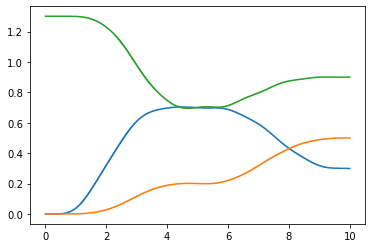

In [76]:
plt.plot(save_t, x)
plt.plot(save_t, y)
plt.plot(save_t, z)

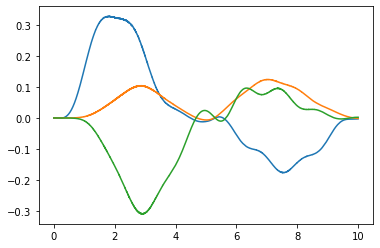

In [77]:
plt.plot(save_t, xx)
plt.plot(save_t, yy)
plt.plot(save_t, zz)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

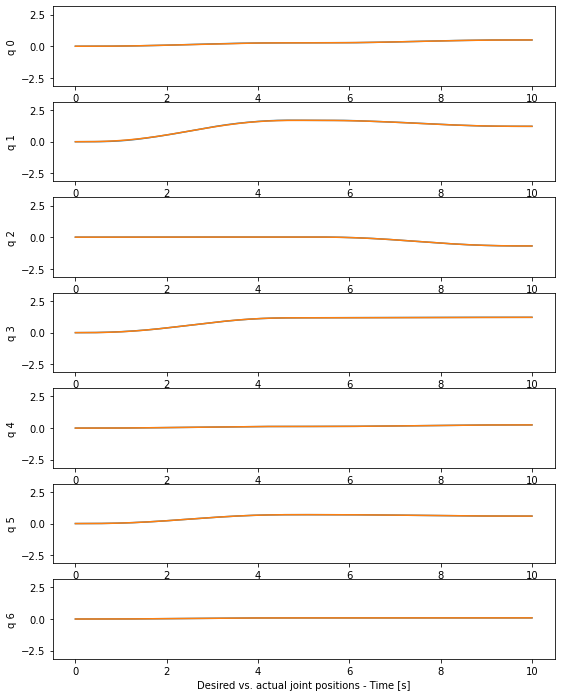

In [123]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

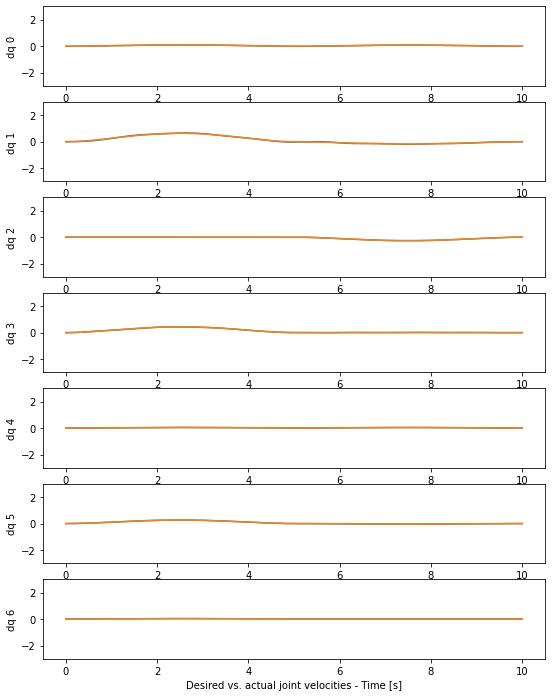

In [124]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

## Question 3: End-effector control
As in Question 2, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Modify the ``robot_controller2`` function below to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions and directly mapping end-effector error to desired joint velocities (i.e. use P gains equal to 0 in joint space and do resolved-rate control).
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare results with Question 2
* Add a nullspace term to optimize a desired configuration of your choice and discuss the results

In [18]:
T = 10.

x2 = []
y2 = []
z2 = []
xx2 = []
yy2 = []
zz2 = []

end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller2(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    
    # 1: Obtain the jacobian w.r.t frame 3

    T_homogeneous = forward_kinematics(joint_positions)
    currp = T_homogeneous[0:3,3]
    currp = np.reshape(currp, (3,1))
    j = get_space_jacobian(joint_positions)
    Jetha = get_spaceoribody_jacobian(T_homogeneous,j)
    J = Jetha[3:,:]
    #J_sudo = sudo_jacobian_regularization(J, 0.00001)
    J_sudo = np.linalg.pinv(J)
    

    
    a = T_homogeneous[0][3]
    b = T_homogeneous[1][3]
    c = T_homogeneous[2][3]
    x2.append(a)
    y2.append(b)
    z2.append(c)
    
    endeffector_twist = Jetha @ joint_velocities
    current_velocity = endeffector_twist[3:,:]
    d = current_velocity[0][0]
    e = current_velocity[1][0]
    f = current_velocity[2][0]
    xx2.append(d)
    yy2.append(e)
    zz2.append(f)
    
    # 2: Retreive the last three columns of its pseudo inv

    #J_sudo = np.reshape(J_sudo[:, 3:6], (7,3))
    
    
    

    if t < 5.:
      djp_f, djv_f = get_point_to_point_motion(5, np.array([[0],[0],[1.301]]), end_effector_goal1)
      desired_endeffector_positions = djp_f(t)
      desired_endeffector_velocities = djv_f(t)
    elif t > 5.:
      djp_f, djv_f = get_point_to_point_motion(5, end_effector_goal1, end_effector_goal2)
      desired_endeffector_positions = djp_f(t-5)
      desired_endeffector_velocities = djv_f(t-5)
    
    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    
    P = np.array([10.,10.,10.])
    D = np.array([4.,4,4,4,4,4,4.])
    
    ##TODO - find the desired joint velocities
    desired_joint_velocities = (J_sudo @ (desired_endeffector_velocities + np.diag(P) @ (desired_endeffector_positions - currp)))
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller2, T=T)

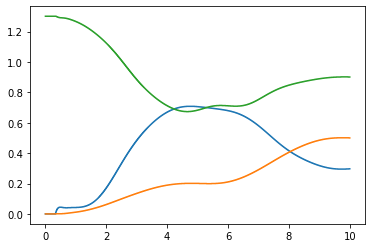

In [81]:
plt.plot(save_t, x2)
plt.plot(save_t, y2)
plt.plot(save_t, z2)

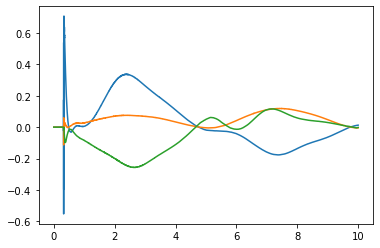

In [82]:
plt.plot(save_t, xx2)
plt.plot(save_t, yy2)
plt.plot(save_t, zz2)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

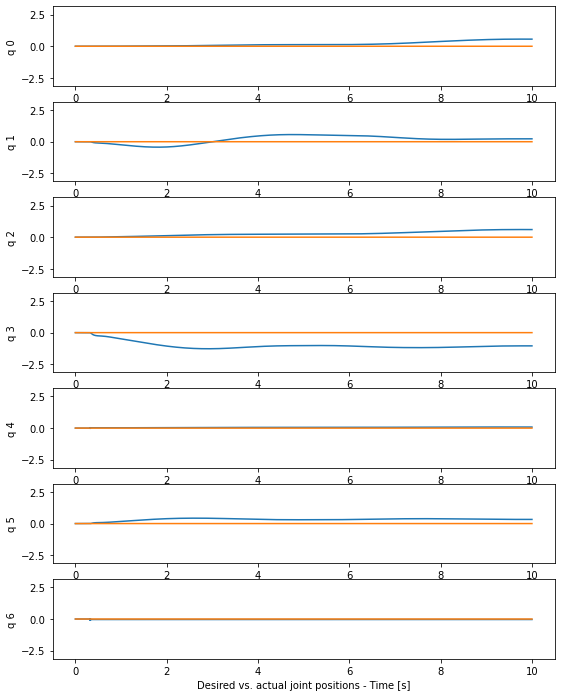

In [40]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

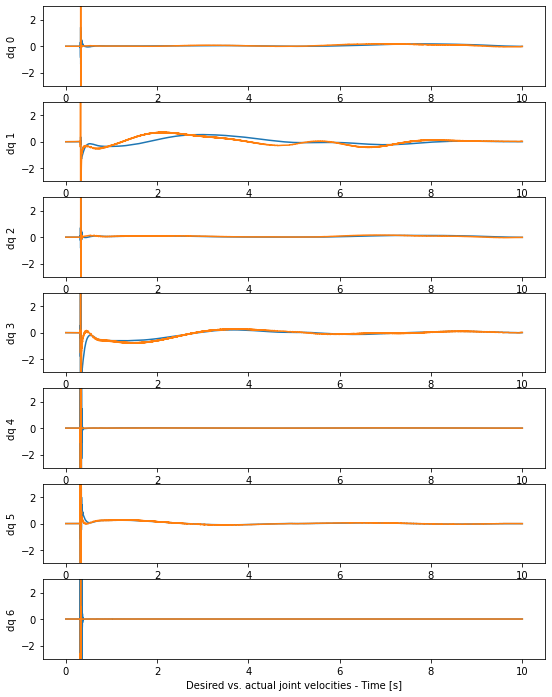

In [41]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

In [20]:
T = 10.

x2 = []
y2 = []
z2 = []
xx2 = []
yy2 = []
zz2 = []

end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller2(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    
    # 1: Obtain the jacobian w.r.t frame 3

    T_homogeneous = forward_kinematics(joint_positions)
    currp = T_homogeneous[0:3,3]
    currp = np.reshape(currp, (3,1))
    j = get_space_jacobian(joint_positions)
    Jetha = get_spaceoribody_jacobian(T_homogeneous,j)
    J = Jetha[3:,:]
    #J_sudo = sudo_jacobian_regularization(J, 0.00001)
    J_sudo = np.linalg.pinv(J)
    
    a = T_homogeneous[0][3]
    b = T_homogeneous[1][3]
    c = T_homogeneous[2][3]
    x2.append(a)
    y2.append(b)
    z2.append(c)
    
    endeffector_twist = Jetha @ joint_velocities
    current_velocity = endeffector_twist[3:,:]
    d = current_velocity[0][0]
    e = current_velocity[1][0]
    f = current_velocity[2][0]
    xx2.append(d)
    yy2.append(e)
    zz2.append(f)
    
    # 2: Retreive the last three columns of its pseudo inv
    
    Take = forward_kinematics(joint_positions)
    Jake = get_space_jacobian(joint_positions)
    Jake = get_spaceoribody_jacobian(Take,Jake)
    Jjake = J[3:,:]
    J_sudop = np.linalg.pinv(Jake)
    nul_P = np.eye(7) - (J_sudop @ Jake)
    q_pose = np.array([1,1,-1,-1,1,1,1])
    null_Q = (q_pose - joint_positions)
    #print(null_Q.size)

    #J_sudo = np.reshape(J_sudo[:, 3:6], (7,3))

    if t < 5.:
      djp_f, djv_f = get_point_to_point_motion(5, np.array([[0],[0],[1.301]]), end_effector_goal1)
      desired_endeffector_positions = djp_f(t)
      desired_endeffector_velocities = djv_f(t)
    elif t > 5.:
      djp_f, djv_f = get_point_to_point_motion(5, end_effector_goal1, end_effector_goal2)
      desired_endeffector_positions = djp_f(t-5)
      desired_endeffector_velocities = djv_f(t-5)
    
    # here we will only use a D controller (i.e. on the desired joint velocities)
    # we increased the D gain for that purpose compared to the previous controller
    
    P = np.array([10.,10.,10.])
    D = np.array([4.,4,4,4,4,4,4.])
    
    ##TODO - find the desired joint velocities
    desired_joint_velocities = (J_sudo @ (desired_endeffector_velocities + np.diag(P) @ (desired_endeffector_positions - currp)))
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller2, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

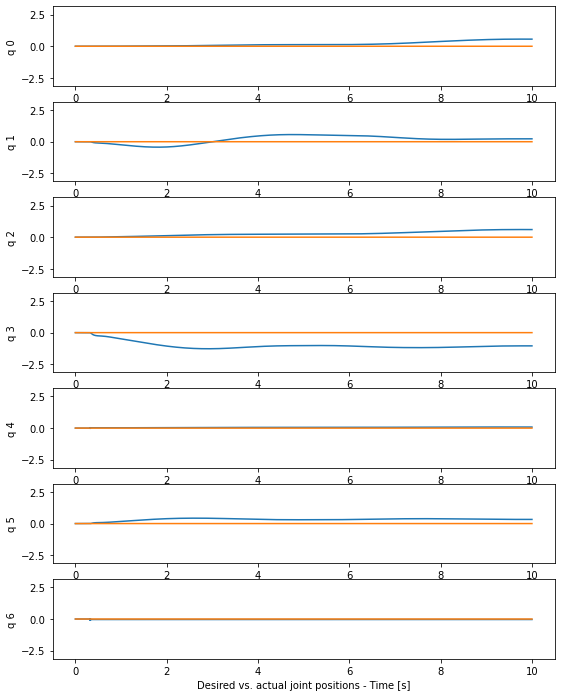

In [21]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

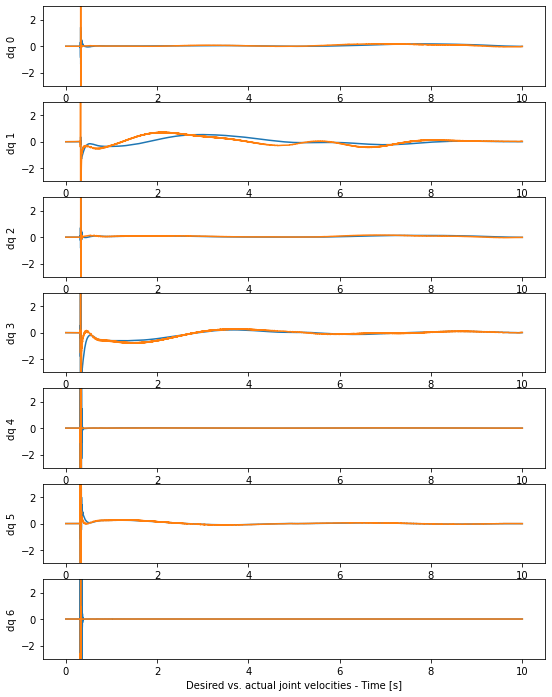

In [22]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

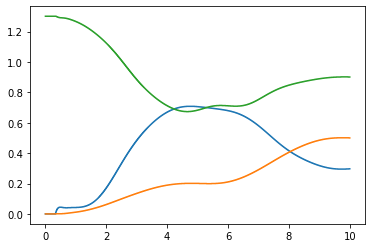

In [23]:
plt.plot(save_t, x2)
plt.plot(save_t, y2)
plt.plot(save_t, z2)

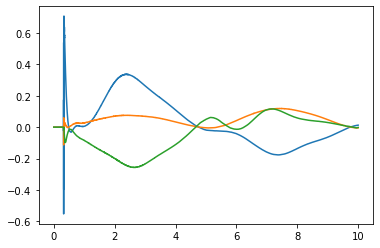

In [24]:
plt.plot(save_t, xx2)
plt.plot(save_t, yy2)
plt.plot(save_t, zz2)

## Question 4: Impedance control and gravity compensation
As in Question 2 and 3, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

In the previous questions, a gravity compensation controller was running "in the background" in addition to the control law you were computing. In this question, we remove this and implement a complete impedance controller with gravity compensation.

You are given a function ``robot_visualizer.rnea(q,dq,ddq)`` which implements the Recursive Newton Euler Algorithm (RNEA). It takes as arguments a vector of positions, velocities and accelerations, and computes (and returns) the following $M(q) \cdot \ddot{q} + C(q,\dot{q}) + G(q)$

* Modify the ``robot_controller3`` function below to implement an impedance controller with gravity compensation (add a small amount of joint damping, using a joint-space D gain of 0.1). Use this controller to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions as in the previous questions.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare the controller when the small joint samping is on or off - can you explain the difference?
* Compare results with Question 2 and 3. Which controller would you rather choose and why?

In [114]:
T = 10.


end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller3(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    if t < 5.:
      djp_f, djv_f = get_point_to_point_motion(5, np.array([[0],[0],[1.301]]), end_effector_goal1)
      desired_endeffector_positions = djp_f(t)
      desired_endeffector_velocities = djv_f(t)
    elif t > 5.:
      djp_f, djv_f = get_point_to_point_motion(5, end_effector_goal1, end_effector_goal2)
      desired_endeffector_positions = djp_f(t-5)
      desired_endeffector_velocities = djv_f(t-5)
    
   
    
    # here we will only use the D controller to inject small joint damping
    D = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    P = np.array([1000., 1000., 1000.])
    D3 = np.array([10, 10, 10,])
    
    ##TODO - implement gravity compensation and impedance control
    
    g = robot_visualizer.rnea(joint_positions,np.zeros([7,1]),np.zeros([7,1]))
    
    Tf = forward_kinematics(joint_positions)
    current_position = np.reshape(Tf[0:3,3], (3,1))
    #print(type(current_position))
    #print(current_position.size)
    Js = get_space_jacobian(joint_positions)
    J = get_spaceoribody_jacobian(Tf,Js)
    Jpos = J[3:,:]
    endeffector_twist = J @ joint_velocities
    current_velocity = endeffector_twist[3:,:]
    
   
    
    desired_joint_torques = np.add((Jpos.T @ (np.add((np.diag(P) @ (desired_endeffector_positions - current_position)),(np.diag(D3) @ (desired_endeffector_velocities - current_velocity))))),g)

    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball([0.7, 0.2,0.7])
robot_visualizer.display_ball2([0.3, 0.5,0.9])
robot_visualizer.simulate_robot(robot_controller3, T=T, gravity_comp = False)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

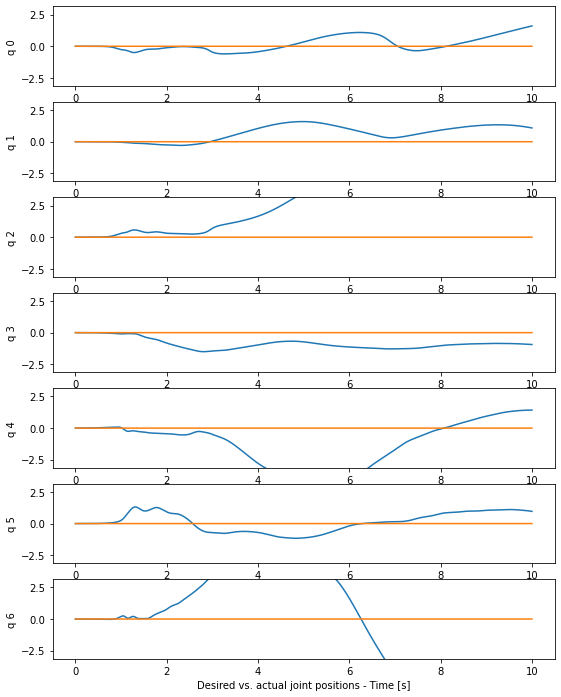

In [115]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

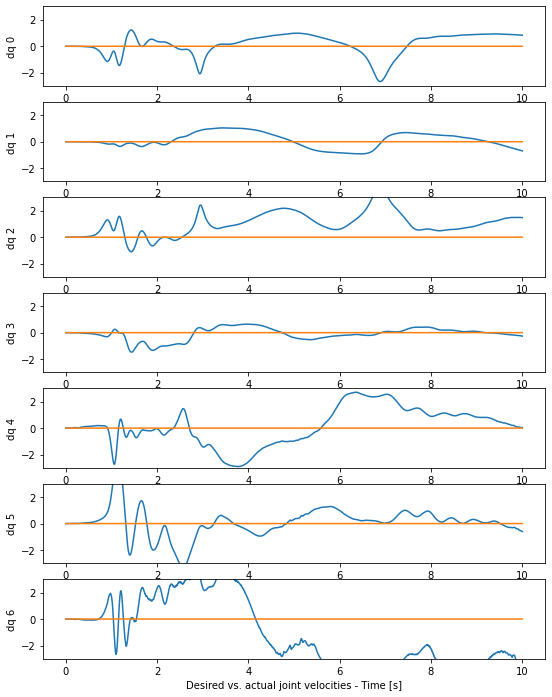

In [116]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

In [120]:
T = 10.


end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

## this code is to save what the controller is doing for plotting and analysis after the simulation
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0
# end of saving code


def robot_controller3(t, joint_positions, joint_velocities):
    """A typical robot controller
        at every time t, this controller is called by the simulator. It receives as input
        the current joint positions and velocities and needs to return a [7,1] vector
        of desired torque commands
        
        As an example, the current controller implements a PD controller and at time = 5s
        it makes joint 2 and 3 follow sine curves
    """
    
    
    
    desired_joint_positions = np.zeros([7,1])
    desired_joint_velocities = np.zeros([7,1])
    
    if t < 5.:
      djp_f, djv_f = get_point_to_point_motion(5, np.array([[0],[0],[1.301]]), end_effector_goal1)
      desired_endeffector_positions = djp_f(t)
      desired_endeffector_velocities = djv_f(t)
    elif t > 5.:
      djp_f, djv_f = get_point_to_point_motion(5, end_effector_goal1, end_effector_goal2)
      desired_endeffector_positions = djp_f(t-5)
      desired_endeffector_velocities = djv_f(t-5)
    
   
    
    # here we will only use the D controller to inject small joint damping
    D = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    P = np.array([1000., 1000., 1000.])
    D3 = np.array([10, 10, 10,])
    
    ##TODO - implement gravity compensation and impedance control
    
    g = robot_visualizer.rnea(joint_positions,np.zeros([7,1]),np.zeros([7,1]))
    
    Tf = forward_kinematics(joint_positions)
    current_position = np.reshape(Tf[0:3,3], (3,1))
    #print(type(current_position))
    #print(current_position.size)
    Js = get_space_jacobian(joint_positions)
    J = get_spaceoribody_jacobian(Tf,Js)
    Jpos = J[3:,:]
    endeffector_twist = J @ joint_velocities
    current_velocity = endeffector_twist[3:,:]
    
   
    
    desired_joint_torques = np.add((Jpos.T @ (np.add((np.diag(P) @ (desired_endeffector_positions - current_position)),(np.diag(D3) @ (desired_endeffector_velocities - current_velocity))))),g) 

    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques - np.diag(D) @ joint_velocities
        
robot_visualizer.display_ball([0.7, 0.2,0.7])
robot_visualizer.display_ball2([0.3, 0.5,0.9])
robot_visualizer.simulate_robot(robot_controller3, T=T, gravity_comp = False)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

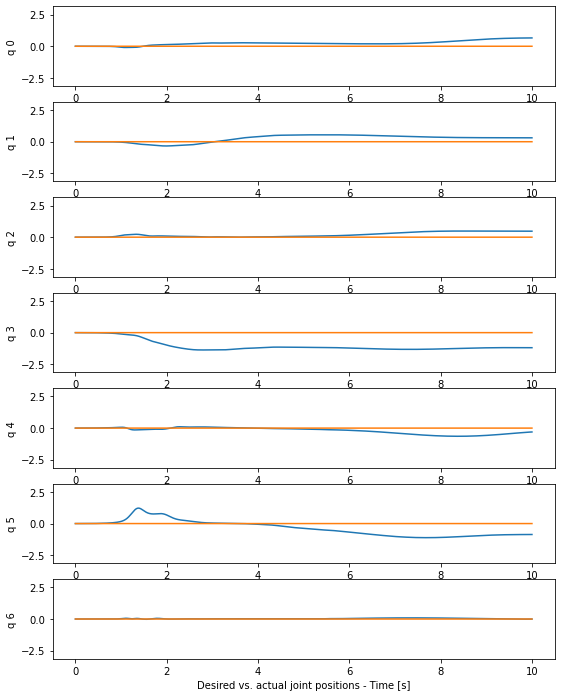

In [121]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-np.pi,np.pi])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

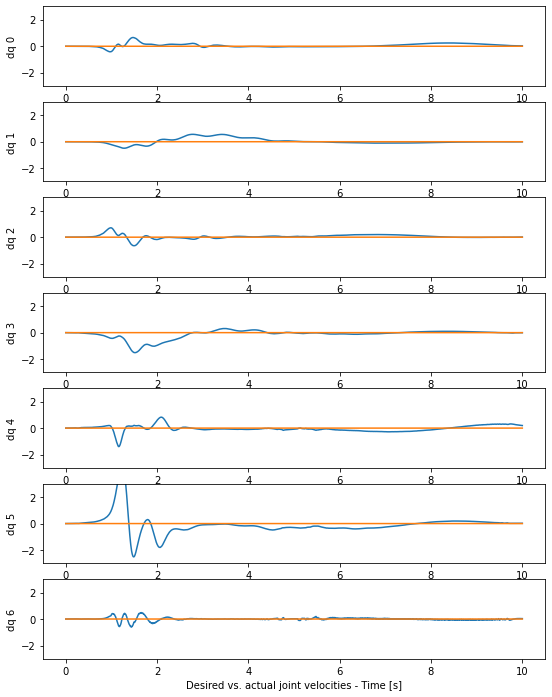

In [122]:
# we plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')